# 1. Resources

In [18]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

# PyTorch
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

In [19]:
torch.__version__

'1.9.0'

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [21]:
# Imagenet normalization
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  # augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# 2. Dataset and dataloader

In [22]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"
experiment = "mat"
# Define parameter
batch_size = 64
num_workers = 2

In [24]:
# Dataset
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])
# Loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset characteristic

In [ ]:
train_size = len(train_set)
val_size = len(val_set)
num_batches = math.floor(train_size/batch_size)
print(f"Train dataset: {train_size}")
print(f"Val dataset: {val_size}")
print(f"Number of batches: {num_batches}")

In [38]:
label_names = train_set.classes
num_class = len(label_names)
print(f"Number of classes: {num_class}")
print(label_names)

Number of classes: 31
['calf', 'canvas', 'canvas+leather', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'fur', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'jacquard ', 'leather', 'linen', 'lizard', 'microguccissima', 'nylon', 'ostrich', 'pig', 'python', 'quilted leather', 'suede', 'velor', 'velvet']


In [41]:
# Pickle class_name
f = open(label_path, "wb")
f.write(pickle.dumps(label_names))
f.close()

## Visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


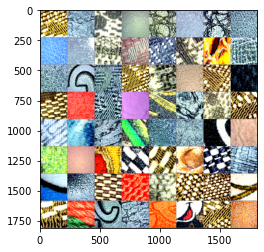

ggcanvas leather coatedcanvas leather leather leather leather leather leather enamel gg supreme canvas canvas canvas gg supreme canvas python leather leather guccissima canvas guccissima gg supreme canvas leather canvas canvas gg crystal leather canvas leather leather leather coatedcanvas canvas gg supreme canvas gg supreme canvas leather gg supreme canvas velvet leather leather leather coatedcanvas leather gg supreme canvas canvas ggcanvas python ggcanvas gg supreme canvas coatedcanvas leather canvas canvas gg plus ggcanvas canvas flora canvas ggcanvas canvas guccissima leather microguccissima gg supreme canvas canvas leather


In [40]:
# Plot some training images
images, labels = next(iter(train_loader))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{label_names[labels[j]]:5s}' for j in range(batch_size)))

# 3. Model

Create the base model from the pre-trained EfficientNetB0

In [29]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train

In [ ]:
num_epochs = 5
learning_rate = 0.01

In [31]:
losses = []
accuracies = []

torch.cuda.empty_cache()

# Initialize network
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Progress bar
outer = tqdm(total=num_epochs+1, unit="epochs", position=0, desc="Epoch")

# Train
epoch_dict = {}
step = 0
for epoch in range(num_epochs):
    inner = tqdm(total=num_batches+1, unit="batches", position=1, desc="Batch")
    batch_log = tqdm(total=0, position=2, bar_format='{desc}')
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)                          # N, C, W, H
        labels = labels.to(device)                          # N

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predictions = outputs.max(1)                     # N
        step_accuracy = (predictions == labels).sum() / inputs.shape[0]
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1        
        
        # Output training stats
        if batch_idx % 50 == 0:
            print("[%d/%d][%d/%d]\tLoss: %.4f\tAccuracy: %.4f"
                  % (epoch, num_epochs, batch_idx, len(train_loader),
                     loss.item(), step_accuracy))
        # Save Losses for plotting later
        losses.append(loss.item())
        accuracies.append(step_accuracy)
        
        # Update progression bar
        batch_log.set_description_str(f"loss: {round(loss.item(), 4)}, accuracy: {step_accuracy}")
        inner.update(1)
    outer.update(1)

print("Training completed.")
        

Epoch:   0%|          | 0/5 [00:00<?, ?epochs/s]

Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[0/5][0/809]	Loss: 3.3876	Accuracy: 0.0781
[0/5][50/809]	Loss: 1.2204	Accuracy: 0.6094
[0/5][100/809]	Loss: 1.0117	Accuracy: 0.6719
[0/5][150/809]	Loss: 0.8710	Accuracy: 0.7812
[0/5][200/809]	Loss: 0.8796	Accuracy: 0.7969
[0/5][250/809]	Loss: 0.7699	Accuracy: 0.7500
[0/5][300/809]	Loss: 0.7338	Accuracy: 0.7656
[0/5][350/809]	Loss: 0.5225	Accuracy: 0.8438
[0/5][400/809]	Loss: 0.8980	Accuracy: 0.7188
[0/5][450/809]	Loss: 0.8262	Accuracy: 0.7656
[0/5][500/809]	Loss: 0.9077	Accuracy: 0.7344
[0/5][550/809]	Loss: 0.7624	Accuracy: 0.7188
[0/5][600/809]	Loss: 0.5580	Accuracy: 0.7812
[0/5][650/809]	Loss: 0.6733	Accuracy: 0.7812
[0/5][700/809]	Loss: 0.5175	Accuracy: 0.8438
[0/5][750/809]	Loss: 0.5158	Accuracy: 0.8438
[0/5][800/809]	Loss: 0.6272	Accuracy: 0.8281


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[1/5][0/809]	Loss: 0.5379	Accuracy: 0.7812
[1/5][50/809]	Loss: 0.5763	Accuracy: 0.8281
[1/5][100/809]	Loss: 0.3999	Accuracy: 0.9062
[1/5][150/809]	Loss: 0.5550	Accuracy: 0.8281
[1/5][200/809]	Loss: 0.4261	Accuracy: 0.8594
[1/5][250/809]	Loss: 0.5392	Accuracy: 0.7812
[1/5][300/809]	Loss: 0.2741	Accuracy: 0.8750
[1/5][350/809]	Loss: 0.4523	Accuracy: 0.8906
[1/5][400/809]	Loss: 0.4081	Accuracy: 0.8438
[1/5][450/809]	Loss: 0.3048	Accuracy: 0.9062
[1/5][500/809]	Loss: 0.3840	Accuracy: 0.9062
[1/5][550/809]	Loss: 0.3948	Accuracy: 0.8438
[1/5][600/809]	Loss: 0.4712	Accuracy: 0.8594
[1/5][650/809]	Loss: 0.2160	Accuracy: 0.9531
[1/5][700/809]	Loss: 0.3537	Accuracy: 0.8438
[1/5][750/809]	Loss: 0.4427	Accuracy: 0.7969
[1/5][800/809]	Loss: 0.4587	Accuracy: 0.8438


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[2/5][0/809]	Loss: 0.2144	Accuracy: 0.8906
[2/5][50/809]	Loss: 0.2995	Accuracy: 0.9219
[2/5][100/809]	Loss: 0.3977	Accuracy: 0.8438
[2/5][150/809]	Loss: 0.1783	Accuracy: 0.9375
[2/5][200/809]	Loss: 0.1729	Accuracy: 0.9375
[2/5][250/809]	Loss: 0.4036	Accuracy: 0.8906
[2/5][300/809]	Loss: 0.2068	Accuracy: 0.9219
[2/5][350/809]	Loss: 0.5074	Accuracy: 0.8281
[2/5][400/809]	Loss: 0.2352	Accuracy: 0.9062
[2/5][450/809]	Loss: 0.3707	Accuracy: 0.7969
[2/5][500/809]	Loss: 0.4024	Accuracy: 0.8594
[2/5][550/809]	Loss: 0.2256	Accuracy: 0.8906
[2/5][600/809]	Loss: 0.3313	Accuracy: 0.9062
[2/5][650/809]	Loss: 0.2678	Accuracy: 0.9062
[2/5][700/809]	Loss: 0.3388	Accuracy: 0.8594
[2/5][750/809]	Loss: 0.2836	Accuracy: 0.8906
[2/5][800/809]	Loss: 0.4190	Accuracy: 0.8750


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[3/5][0/809]	Loss: 0.2958	Accuracy: 0.8438
[3/5][50/809]	Loss: 0.1725	Accuracy: 0.9375
[3/5][100/809]	Loss: 0.3270	Accuracy: 0.8594
[3/5][150/809]	Loss: 0.2618	Accuracy: 0.8906
[3/5][200/809]	Loss: 0.2609	Accuracy: 0.8906
[3/5][250/809]	Loss: 0.3621	Accuracy: 0.8906
[3/5][300/809]	Loss: 0.2217	Accuracy: 0.9375
[3/5][350/809]	Loss: 0.2725	Accuracy: 0.8906
[3/5][400/809]	Loss: 0.2505	Accuracy: 0.8906
[3/5][450/809]	Loss: 0.1971	Accuracy: 0.9688
[3/5][500/809]	Loss: 0.2183	Accuracy: 0.9531
[3/5][550/809]	Loss: 0.3399	Accuracy: 0.8594
[3/5][600/809]	Loss: 0.1896	Accuracy: 0.9219
[3/5][650/809]	Loss: 0.1474	Accuracy: 0.9531
[3/5][700/809]	Loss: 0.1882	Accuracy: 0.9375
[3/5][750/809]	Loss: 0.4339	Accuracy: 0.8750
[3/5][800/809]	Loss: 0.3424	Accuracy: 0.8750


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[4/5][0/809]	Loss: 0.2002	Accuracy: 0.8906
[4/5][50/809]	Loss: 0.3058	Accuracy: 0.9219
[4/5][100/809]	Loss: 0.2618	Accuracy: 0.9219
[4/5][150/809]	Loss: 0.2598	Accuracy: 0.8906
[4/5][200/809]	Loss: 0.1747	Accuracy: 0.8750
[4/5][250/809]	Loss: 0.1866	Accuracy: 0.9375
[4/5][300/809]	Loss: 0.2268	Accuracy: 0.9375
[4/5][350/809]	Loss: 0.2009	Accuracy: 0.8906
[4/5][400/809]	Loss: 0.1240	Accuracy: 0.9531
[4/5][450/809]	Loss: 0.1101	Accuracy: 0.9531
[4/5][500/809]	Loss: 0.2404	Accuracy: 0.9062
[4/5][550/809]	Loss: 0.0896	Accuracy: 0.9844
[4/5][600/809]	Loss: 0.1558	Accuracy: 0.9375
[4/5][650/809]	Loss: 0.2587	Accuracy: 0.9062
[4/5][700/809]	Loss: 0.1002	Accuracy: 0.9688
[4/5][750/809]	Loss: 0.2359	Accuracy: 0.9062
[4/5][800/809]	Loss: 0.1271	Accuracy: 0.9375
Training completed.


In [32]:
# Save model parameters
params_path = "./mat/params"
torch.save(model.state_dict(), params_path)

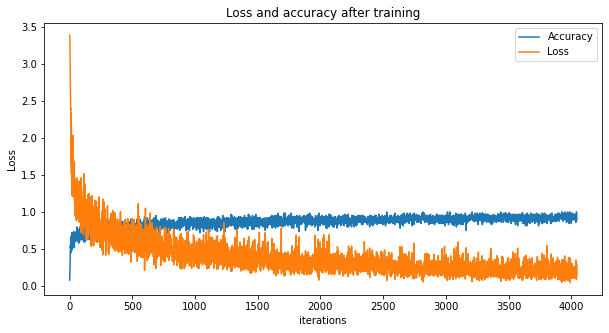

In [33]:
# Plot
plt.figure(figsize=(10,5))
plt.title("Loss and accuracy after training")
plt.plot(accuracies,label="Accuracy")
plt.plot(losses,label="Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 4. Validation

In [34]:
model.eval()

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


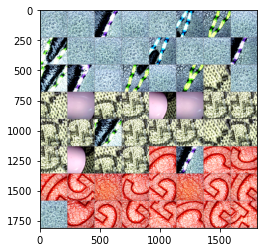

GroundTruth:  calf  calf  calf  calf 


In [42]:
images, labels = iter(val_loader).next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{label_names[labels[j]]:5s}' for j in range(4)))

In [43]:
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{label_names[predicted[j]]:5s}' for j in range(4)))

Predicted:  leather leather leather leather


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 25 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in label_names}
total_pred = {classname: 0 for classname in label_names}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label_names[label]] += 1
            total_pred[label_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: calf  is 3.5 %
Accuracy for class: canvas is 83.8 %
Accuracy for class: canvas+leather is 0.0 %
Accuracy for class: coatedcanvas is 50.4 %
Accuracy for class: crocodile is 0.0 %
Accuracy for class: denim is 56.5 %
Accuracy for class: enamel is 0.0 %
Accuracy for class: flora canvas is 79.6 %
Accuracy for class: fur   is 0.0 %
Accuracy for class: gg crystal is 69.6 %
Accuracy for class: gg embossed leather is 71.1 %
Accuracy for class: gg imprime  is 96.5 %
Accuracy for class: gg nylon is 79.2 %
Accuracy for class: gg plus is 31.0 %
Accuracy for class: gg supreme canvas is 85.3 %
Accuracy for class: ggcanvas is 41.0 %
Accuracy for class: guccissima is 84.3 %
Accuracy for class: guccissima nylon is 75.2 %
Accuracy for class: jacquard  is 100.0 %
Accuracy for class: leather is 75.4 %
Accuracy for class: linen is 95.2 %
Accuracy for class: lizard is 0.0 %
Accuracy for class: microguccissima is 60.8 %
Accuracy for class: nylon is 52.5 %
Accuracy for class: ostrich is 0.0